In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/study/16715robotsim/project/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Test
using Plots

In [60]:
const g = 9.8
const M = [1 0; 0 1]

# set of contact modes
modes = [false; true]

q0 = [0;0.5]
dq0 = [0;0]
x0 = [q0;dq0]
initial_mode = [false]


1-element Vector{Bool}:
 0

In [61]:
# constraints/contacts
function compute_a(q)
    a = q[2]
    return [a]
end

# constraints jacobian
function compute_A(q)
    A = [0 1]
    return A
end

function compute_dA(q, dq)
    dA = [0 0]
    return dA
end

compute_dA (generic function with 1 method)

In [62]:
println(compute_a(q0))
println(compute_A(q0))
println(compute_dA(q0, dq0))

[0.5]
[0 1]
[0 0]


In [79]:
A = compute_A(q0)
A = A[initial_mode,:]
[M A'; A zeros(size(A,1),size(A',2))]

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [120]:
function solveEOM(x, contactMode)
    # contactMode: bool vector, indicates which constraints are active
    q = x[1:2]
    dq = x[3:4]
    
    #Compute A and dA at the current state, only select rows for the current contact mode
    A = compute_A(q)
    dA = compute_dA(q, dq)
    A = A[contactMode,:]
    dA = dA[contactMode,:]
    
    c = size(A,1)
    
    # compute EOM matrices
    N = [0; g]
    C = [0 0; 0 0]
    Y = [0;0]
    
    #
    blockMat = [M A'; A zeros(size(A,1),size(A',2))] 

    b = [Y-N-C*dq; -dA*dq]
    
    z = blockMat\b
    
    ddq = z[1:2]
    if (c>=1)
        λ = z[3:end]
    else
        λ = []
    end
    
    return ddq, λ
end

solveEOM (generic function with 1 method)

In [121]:
#println(solveEOM([0;0.5;0;0],[false]))
#println(solveEOM([0;0;0;0], [true]))
println(solveEOM([0;0.1;0;1], [true]))

([0.0, 0.0], [-9.8])


In [122]:
function computeResetMap(x, contactMode)
    q = x[1:2]
    dq = x[3:4]
    
    A = compute_A(q)
    A = A[contactMode,:]
    
    c = size(A, 1)
    
    blockMat = [M A'; A zeros(size(A,1),size(A',2))] 
    
    z = blockMat\[M*dq; zeros(c)]
    
    dq_p = z[1:2]
    p_hat = z[3:end]
    return dq_p, p_hat
end

computeResetMap (generic function with 1 method)

In [123]:
println(computeResetMap([0;0;-1;-1], [true]))

([-1.0, 0.0], [-1.0])


In [124]:
function compute_FA(x)
    q = x[1:2]
    dq = x[3:4]
    
    a = compute_a(q)
    
    active_a = abs.(a) .< 1e-6
    inactive_a = abs.(a) .> 1e-6
    
    all_m = active_a #all-constraints-active mode
    contactMode = all_m
    possibleModes = zeros(Bool, 0, size(modes,2))
    
    for k = 1:size(modes,1)
        m = modes[k, :]
        if length(findall(z->z==true, m[inactive_a])) == 0
            possibleModes = [possibleModes; m]
        end
    end
    
    ddq_union, λ_union = solveEOM(x, all_m)
    
    active_idx = findall(z->z==true,all_m)
    all_m_active = all_m[active_idx]
    
    for kk = 1:size(possibleModes, 1)
        m = possibleModes[kk,:]
        ddq, λ = solveEOM(x, m)
        
        m_active = m[active_idx]
        
        if all(-λ.>=0) && all(-λ_union[m_active.!=all_m_active].<=0)
            contactMode = m
            break;
        end
    end
    
    return contactMode
end

compute_FA (generic function with 1 method)

In [126]:
println(compute_FA([0;0.1;0;2]))

λ_union Any[]
m_active Bool[]
Bool[0]


In [129]:
function compute_IV(x)
    
    q = x[1:2]
    dq = x[3:4]
    
    a = compute_a(q)
    
    active_a = abs.(a) .< 1e-6
    inactive_a = abs.(a) .> 1e-6
    
    all_m = active_a #all-constraints-active mode
    contactMode = all_m
    possibleModes = zeros(Bool, 0, size(modes,2))
    
    for k = 1:size(modes,1)
        m = modes[k, :]
        if length(findall(z->z==true, m[inactive_a])) == 0
            possibleModes = [possibleModes; m]
        end
    end
    
    dq_p_union, p_hat_union = computeResetMap(x, all_m)
    
    active_idx = findall(z->z==true,all_m)
    all_m_active = all_m[active_idx]
    
    for kk = 1:size(possibleModes, 1)
        m = possibleModes[kk,:]
        m_active = m[active_idx]
        dq_p, p_hat = computeResetMap(x, m)
        
        if all(-p_hat.>=0) && all(-p_hat_union[m_active.!=all_m_active].<=0)
            contactMode = m
            break;
        end
    end
    
    return contactMode
end

compute_IV (generic function with 1 method)

In [136]:
println(compute_IV([0;1;0;-1]))
println(compute_IV([0;0;-1;-1]))
println(compute_IV([0;1;-1;1]))

Bool[0]
Bool[1]
Bool[0]


In [139]:
function guard_conditions(x, contactMode)
    q = x[1:2]
    dq = x[3:4]
    
    a = compute_a(q)
    a[contactMode .== true] .= 0.0
    
    λ_all = zeros(length(a))
    
    ddq, λ = solveEOM(x, contactMode)
    
    λ_all[contactMode .== true] = λ
    
    c = [a; λ]
    
    dir = [-ones(Int,length(a)); ones(Int,length(λ_all))]
    
    return c, dir
end

guard_conditions (generic function with 1 method)

In [145]:
guard_conditions([0;0;0;1],[true])

([0.0, -9.8], [-1, 1])

In [146]:
function dynamics!(dx, x, m, t)
    # m: vector n, contact mode
    q = x[1:2]
    dq = x[3:4]
    ddq, λ = solveEOM(x, m)
    dx .= [dq; ddq]
end

dynamics! (generic function with 1 method)

In [149]:
function conditions(out, x, t, integrator)
    contactMode = integrator.p
    c, dir = guard_conditions(x, contactMode)
    out .= c
end

function affect!(integrator, idx)
    contactMode = integrator.p
    x = integrator.u
    c, dir = guard_conditions(x, contactMode)
    
    # only consider upcrossing forces and constraints values(FA comp)
    # forces
    if dir[idx] > 0
        new_contactMode = compute_FA(x)
        integrator.p .= new_contactMode
    end
    # constraints
#     if dir[idx] < 0
#         new_contactMode = contactMode
#         new_contactMode[idx] = false
#     end
end

function affect_neg!(integrator, idx)
    contactMode = integrator.p
    x = integrator.u
    c, dir = guard_conditions(x, contactMode)
    
    # only consider down crossing constraint value(IV comp)
    if dir[idx] < 0
        new_contactMode = compute_IV(x)
        dq_p, p_hat = computeResetMap(x, new_contactMode)
        integrator.u .= [x[1:2]; dq_p]
        integrator.p .= new_contactMode
    end
end

affect_neg! (generic function with 1 method)

In [186]:
tspan = (0.0, 5.0)
callback_length = 2

x0 = [0;0;0.5;1.1]
initial_mode = [false]
prob = ODEProblem(dynamics!, x0, tspan, initial_mode)
cb = VectorContinuousCallback(conditions, affect!, affect_neg!, callback_length)
sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 31-element Vector{Float64}:
 0.0
 0.00028970819746309184
 0.0008030164482933246
 0.001646948717520041
 0.0029453776738481213
 0.004842317891971796
 0.007564400135632293
 0.011384145609739355
 0.016637352584220097
 0.0237369587973726
 0.03315040314485658
 0.04531861956829398
 0.060890186418935725
 ⋮
 0.22448979591836749
 0.2750717979211704
 0.3796622900986997
 0.5245401883132145
 0.7286999060612243
 1.011889738524467
 1.4005008493805144
 1.928973091284801
 2.642484213558063
 3.600414853501061
 4.880969973533411
 5.0
u: 31-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.5, 1.1]
 [0.0001448540987315459, 0.00031826775609498226, 0.5, 1.0971608596648619]
 [0.0004015082241466622, 0.000880158399583132, 0.5, 1.0921304388067257]
 [0.0008234743587600203, 0.0017983526328891543, 0.5, 1.0838599025683038]
 [0.0014726888369240602, 0.003197406717989078, 0.5, 1.0711352987962885]
 [0.0024211589459858978, 0.005211654272591115, 0.

┌ Info: Saved animation to 
│   fn = /home/xianyi/study/16715robotsim/project/src/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/study/16715robotsim/project/src/anim.gif")
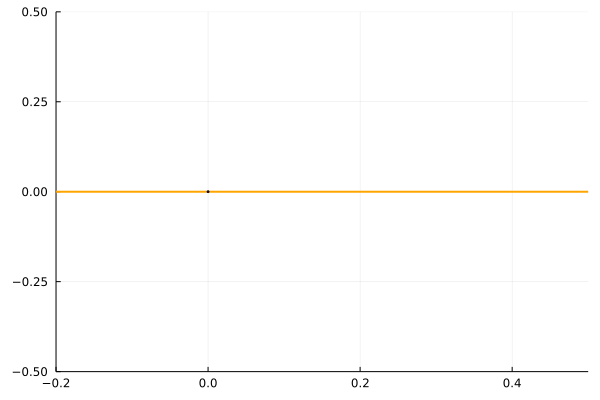

In [189]:
# animation 
n = length(sol.t)
x = zeros(n)
y = zeros(n)
for k = 1:n
    x[k] = sol.u[k][1]
    y[k] = sol.u[k][2]
end
    
plot([-10,5],[0,0], lw = 2, c=:orange, xlims=(-0.2,0.5), ylims=(-0.5,0.5))
anim = @animate for i ∈ 1:n
    
    scatter!([x[i]], [y[i]],
         m=:circle, c=:blue,
         markersize=2, legend = false)
    
end
gif(anim, "anim.gif", fps = 1/(tspan[2]/n))

Todo 
- set some values and test each function





















